# Figure 2 (Baseline Analysis)

In [4]:
import os

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [5]:
# Replace with the path to where you store data
DATA_PATH = "../../cnt-data/"

In [6]:
# This is the example patient's HUP ID
patient_hup_id = 142

# Load in the patient's "giant table"
hourly_patient_features_df = pd.read_csv(
    os.path.join(DATA_PATH, f"giant_new_tables/HUP_{str(patient_hup_id)}.csv")
)

## Figure 2 (C)

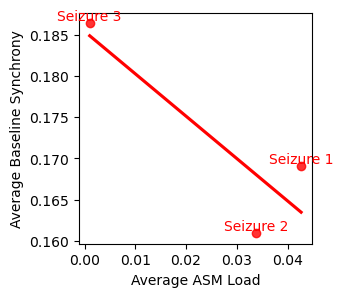

In [7]:
# Assuming you have the hourly_patient_features_df from somewhere above
seizure_indices = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
].index

valid_seizure_indices = [
    idx
    for i, idx in enumerate(seizure_indices)
    if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 120
]

avg_synchronies = []
avg_med_loads = []

for idx in valid_seizure_indices:
    seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

    window = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
        & (hourly_patient_features_df["emu_minute"] < seizure_time - 20)
    ]

    avg_synchrony = np.nanmean(window["synchrony_broadband"])
    avg_med_load = np.nanmean(window["med_sum_no_lorazepam_raw"])

    avg_synchronies.append(avg_synchrony)
    avg_med_loads.append(avg_med_load)

if avg_med_loads and avg_synchronies:
    plt.figure(figsize=(3, 3))  # Add this line to create a standalone figure
    sns.regplot(
        x=avg_med_loads,
        y=avg_synchronies,
        scatter=True,
        line_kws={"color": "red"},
        ci=None,
        color="red",
    )

    # Label each dot with its respective seizure number
    for i, (x, y) in enumerate(zip(avg_med_loads, avg_synchronies)):
        plt.text(
            x, y, f"Seizure {i+1}", fontsize=10, ha="center", va="bottom", color="red"
        )

    plt.xlabel("Average ASM Load")
    plt.ylabel("Average Baseline Synchrony")
    # plt.title(f"Baseline Synchrony vs ASM")
    plt.show()  # Add this line to display the plot

## Figure 2 (D)

In [8]:
def get_patient_hup_ids(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files based on the given pattern and extract patient_hup_id as integers
    patient_hup_ids = [
        int(f.split("_")[1].split(".")[0]) for f in files if f.startswith("HUP_")
    ]

    return patient_hup_ids


TABLES_PATH = os.path.join(DATA_PATH, "giant_new_tables")
completed_hup_ids = get_patient_hup_ids(TABLES_PATH)
completed_hup_ids.sort()

In [9]:
completed_hup_ids

[137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 177,
 178,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 196,
 199,
 202,
 204,
 205,
 206,
 207,
 210,
 217,
 219,
 221,
 223,
 225]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.712
Date:                Wed, 11 Sep 2024   Prob (F-statistic):             0.0315
Time:                        23:48:10   Log-Likelihood:                 325.83
No. Observations:                 154   AIC:                            -647.7
Df Residuals:                     152   BIC:                            -641.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1253      0.004     35.616      0.0

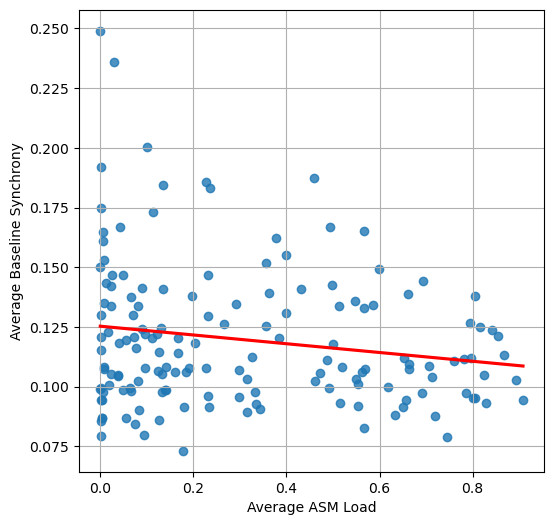

In [10]:
def get_seizure_data(hourly_patient_features_df):
    """
    For a given hourly_patient_features_df, return a list of tuples.
    Each tuple contains avg_med_load and avg_synchrony for each seizure.
    """
    seizure_indices = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ].index

    valid_seizure_indices = [
        idx
        for i, idx in enumerate(seizure_indices)
        if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 5 * 60
    ]

    seizure_data = []

    for idx in valid_seizure_indices:
        seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 60)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]
        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            continue  # Skip the rest of the current iteration

        avg_synchrony = np.nanmedian(window["synchrony_broadband"])
        avg_med_load = np.nanmedian(window["med_sum_no_lorazepam_raw"])

        if avg_synchrony < 0.6:
            seizure_data.append((avg_med_load, avg_synchrony))

    return seizure_data


# Accumulate data from all patients
all_seizures_data = []

for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )
    all_seizures_data.extend(get_seizure_data(hourly_patient_features_df))

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)

# Convert tuples to lists
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

# Fit an OLS regression model
X = sm.add_constant(avg_med_loads_list)  # Adding a constant for the intercept
model = sm.OLS(avg_synchronies_list, X).fit()

# Print out the statistics
print(model.summary())

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.grid(True)
plt.show()

## Figure 2 (E)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.668
Date:                Wed, 11 Sep 2024   Prob (F-statistic):              0.202
Time:                        23:48:12   Log-Likelihood:                 127.26
No. Observations:                  61   AIC:                            -250.5
Df Residuals:                      59   BIC:                            -246.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1248      0.006     20.990      0.0

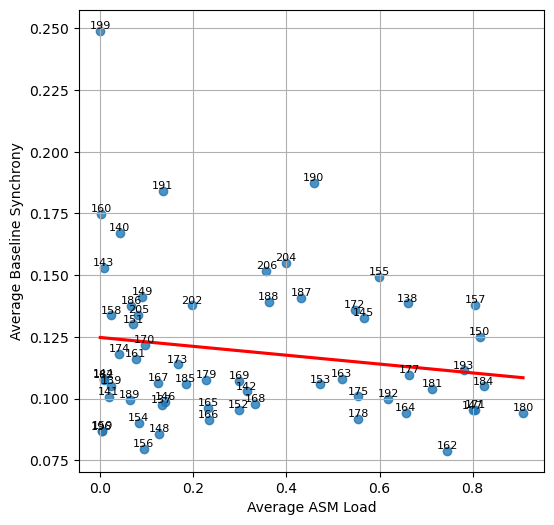

In [11]:
all_seizures_data = []

# Iterate through all patient data
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Get only the first seizure index
    first_seizure_idx = (
        hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].index[0]
        if not hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].empty
        else None
    )

    if first_seizure_idx:
        seizure_time = hourly_patient_features_df.loc[first_seizure_idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 60)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]

        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            continue  # Skip the rest of the current iteration

        avg_synchrony = np.nanmedian(window["synchrony_broadband"])
        avg_med_load = np.nanmedian(window["med_sum_no_lorazepam_raw"])

        if avg_synchrony < 0.6:
            all_seizures_data.append((avg_med_load, avg_synchrony))

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

# Fit an OLS regression model
X = sm.add_constant(avg_med_loads_list)  # Adding a constant for the intercept
model = sm.OLS(avg_synchronies_list, X).fit()

# Print out the statistics
print(model.summary())

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

for i, (x, y) in enumerate(zip(avg_med_loads_list, avg_synchronies_list)):
    plt.text(x, y, f"{completed_hup_ids[i]}", fontsize=8, ha="center", va="bottom")

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.grid(True)
plt.show()

In [12]:
!jupyter nbconvert --to python figure_2.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook figure_2.ipynb to python
[NbConvertApp] Writing 7195 bytes to figure_2.py
